# <font color="grey">Libraries and utility functions</font>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set_style("darkgrid")
import plotly
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import pylab
import uuid
import plotly.express as px
import plotly.offline as pyo
import plotly.graph_objs as go
import plotly.io as pio
pio.renderers.default='notebook'
plotly.offline.init_notebook_mode(connected=True)
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture

In [2]:
def draw_ellipse(position, covariance, ax=None, **kwargs):
    ax = ax or plt.gca()
    
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # Draw the ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height, angle, **kwargs))

In [3]:
def plot_gmm(gmm, X, label=True, ax=None):
    ax = ax or plt.gca()
    labels = gmm.fit(X).predict(X)
    if label:
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)
    else:
        ax.scatter(X[:, 0], X[:, 1], s=40, zorder=2)
    ax.axis('equal')
    
    w_factor = 0.2 / gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
        draw_ellipse(pos, covar, alpha=w * w_factor)

In [4]:
def visualize_clustered_data_2d_plotly(data_2d, labels, info):
    fig = px.scatter(x=data_2d[:,0], y=data_2d[:,1], color=labels.astype(str), labels={
                    "x" : "Component 1",
                    "y" : "Component 2",
                    "color" : "Cluster Label"
                 },
                     title="{} {} clusters (params: {})".format(info["algorithm"], info["n_clusters"], info["params"])
          )
    fig.show()

In [5]:
def visualize_clustered_data_2d(data_2d, labels, info):
    plt.figure(figsize = (15, 15))
    sns.color_palette("rocket")
    sns.scatterplot(x=data_2d[:,0], y=data_2d[:,1], hue=labels.astype(str))

In [6]:
def visualize_clustered_data_3d_plotly(data_3d, labels, info):
    fig = px.scatter_3d(x=data_3d[:,0], y=data_3d[:,1], z=data_3d[:,2], color=labels.astype(int), labels={
                    "x" : "Component 1",
                    "y" : "Component 2",
                    "z" : "Component 3",
                    "color" : "Cluster Label"
                 },
                     title="{} {} clusters (params: {})".format(info["algorithm"], info["n_clusters"], info["params"])
          )
    fig.show()

In [7]:
def visualize_clustered_data_3d(data_3d, labels, info):
    fig = plt.figure(figsize = (15, 15))
    ax = plt.axes(projection ="3d")
    
    p = ax.scatter3D(data_3d[:,0], data_3d[:,1], data_3d[:,1], c = labels.astype(int), cmap=pylab.cm.Oranges)
    cbar = fig.colorbar(p)
    cbar.set_label("Cluster Label")
    
    ax.set_xlabel('Component 1')
    ax.set_ylabel('Component 2')
    ax.set_zlabel('Component 3')

    plt.title("{} {} clusters (params: {})".format(info["algorithm"], info["n_clusters"], info["params"]))

# Load data

In [8]:
df = pd.read_csv('datasets/Data_Cortex_Nuclear.csv')

In [9]:
df.head()

,MouseID,DYRK1A_N,ITSN1_N,BDNF_N,NR1_N,NR2A_N,pAKT_N,pBRAF_N,pCAMKII_N,pCREB_N,...,pCFOS_N,SYP_N,H3AcK18_N,EGR1_N,H3MeK4_N,CaNA_N,Genotype,Treatment,Behavior,class
0,309_1,0.503644,0.747193,0.430175,2.816329,5.990152,0.218830,0.177565,2.373744,0.232224,...,0.108336,0.427099,0.114783,0.131790,0.128186,1.675652,Control,Memantine,C/S,c-CS-m
1,309_2,0.514617,0.689064,0.411770,2.789514,5.685038,0.211636,0.172817,2.292150,0.226972,...,0.104315,0.441581,0.111974,0.135103,0.131119,1.743610,Control,Memantine,C/S,c-CS-m
2,309_3,0.509183,0.730247,0.418309,2.687201,5.622059,0.209011,0.175722,2.283337,0.230247,...,0.106219,0.435777,0.111883,0.133362,0.127431,1.926427,Control,Memantine,C/S,c-CS-m
3,309_4,0.442107,0.617076,0.358626,2.466947,4.979503,0.222886,0.176463,2.152301,0.207004,...,0.111262,0.391691,0.130405,0.147444,0.146901,1.700563,Control,Memantine,C/S,c-CS-m
4,309_5,0.434940,0.617430,0.358802,2.365785,4.718679,0.213106,0.173627,2.134014,0.192158,...,0.110694,0.434154,0.118481,0.140314,0.148380,1.839730,Control,Memantine,C/S,c-CS-m


## Remove unecessary features

In [10]:
df.drop(columns=["class", "Behavior", "Treatment", "Genotype", "MouseID"], inplace=True)

In [11]:
df.head()

,DYRK1A_N,ITSN1_N,BDNF_N,NR1_N,NR2A_N,pAKT_N,pBRAF_N,pCAMKII_N,pCREB_N,pELK_N,...,SHH_N,BAD_N,BCL2_N,pS6_N,pCFOS_N,SYP_N,H3AcK18_N,EGR1_N,H3MeK4_N,CaNA_N
0,0.503644,0.747193,0.430175,2.816329,5.990152,0.218830,0.177565,2.373744,0.232224,1.750936,...,0.188852,0.122652,NaN,0.106305,0.108336,0.427099,0.114783,0.131790,0.128186,1.675652
1,0.514617,0.689064,0.411770,2.789514,5.685038,0.211636,0.172817,2.292150,0.226972,1.596377,...,0.200404,0.116682,NaN,0.106592,0.104315,0.441581,0.111974,0.135103,0.131119,1.743610
2,0.509183,0.730247,0.418309,2.687201,5.622059,0.209011,0.175722,2.283337,0.230247,1.561316,...,0.193685,0.118508,NaN,0.108303,0.106219,0.435777,0.111883,0.133362,0.127431,1.926427
3,0.442107,0.617076,0.358626,2.466947,4.979503,0.222886,0.176463,2.152301,0.207004,1.595086,...,0.192112,0.132781,NaN,0.103184,0.111262,0.391691,0.130405,0.147444,0.146901,1.700563
4,0.434940,0.617430,0.358802,2.365785,4.718679,0.213106,0.173627,2.134014,0.192158,1.504230,...,0.205604,0.129954,NaN,0.104784,0.110694,0.434154,0.118481,0.140314,0.148380,1.839730


# Exploratory Data Analysis (EDA)

## Data structure

In [12]:
df.isna().any()

DYRK1A_N      True
ITSN1_N       True
BDNF_N        True
NR1_N         True
NR2A_N        True
             ...  
SYP_N        False
H3AcK18_N     True
EGR1_N        True
H3MeK4_N      True
CaNA_N       False
Length: 77, dtype: bool

<font color="red"><strong>Conclusion:</strong></font> There are missing values in data, and we are going to impute them with one of the simplest techniques, i.e. Mean Imputation (Mean Substitution). This method would not yield the best results.

In [13]:
df = df.apply(lambda x: x.fillna(x.mean()),axis=0)

In [14]:
df.describe()

,DYRK1A_N,ITSN1_N,BDNF_N,NR1_N,NR2A_N,pAKT_N,pBRAF_N,pCAMKII_N,pCREB_N,pELK_N,...,SHH_N,BAD_N,BCL2_N,pS6_N,pCFOS_N,SYP_N,H3AcK18_N,EGR1_N,H3MeK4_N,CaNA_N
count,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000,...,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000
mean,0.425810,0.617102,0.319088,2.297269,3.843934,0.233168,0.181846,3.537109,0.212574,1.428682,...,0.226676,0.157914,0.134762,0.121521,0.131053,0.446073,0.169609,0.183135,0.205440,1.337784
std,0.249015,0.251290,0.049314,0.346810,0.931802,0.041577,0.027004,1.293368,0.032542,0.466254,...,0.028989,0.026461,0.023519,0.014276,0.023018,0.066432,0.054222,0.036261,0.048069,0.317126
min,0.145327,0.245359,0.115181,1.330831,1.737540,0.063236,0.064043,1.343998,0.112812,0.429032,...,0.155869,0.088305,0.080657,0.067254,0.085419,0.258626,0.079691,0.105537,0.101787,0.586479
25%,0.288163,0.473669,0.287650,2.059152,3.160287,0.205821,0.164619,2.479861,0.190828,1.206389,...,0.206395,0.141045,0.119986,0.110839,0.114373,0.398082,0.133969,0.159168,0.174271,1.081423
50%,0.366540,0.566365,0.316703,2.297269,3.763306,0.231246,0.182270,3.329624,0.210681,1.356368,...,0.224000,0.157914,0.134762,0.121626,0.128466,0.448459,0.169609,0.183135,0.205440,1.317441
75%,0.487574,0.697500,0.348039,2.528035,4.425107,0.257225,0.197226,4.480652,0.234558,1.560931,...,0.241655,0.167584,0.139331,0.131955,0.142427,0.490773,0.187174,0.196133,0.219242,1.585824
max,2.516367,2.602662,0.497160,3.757641,8.482553,0.539050,0.317066,7.464070,0.306247,6.113347,...,0.358289,0.282016,0.261506,0.158748,0.256529,0.759588,0.479763,0.360692,0.413903,2.129791


## Between feature correlation

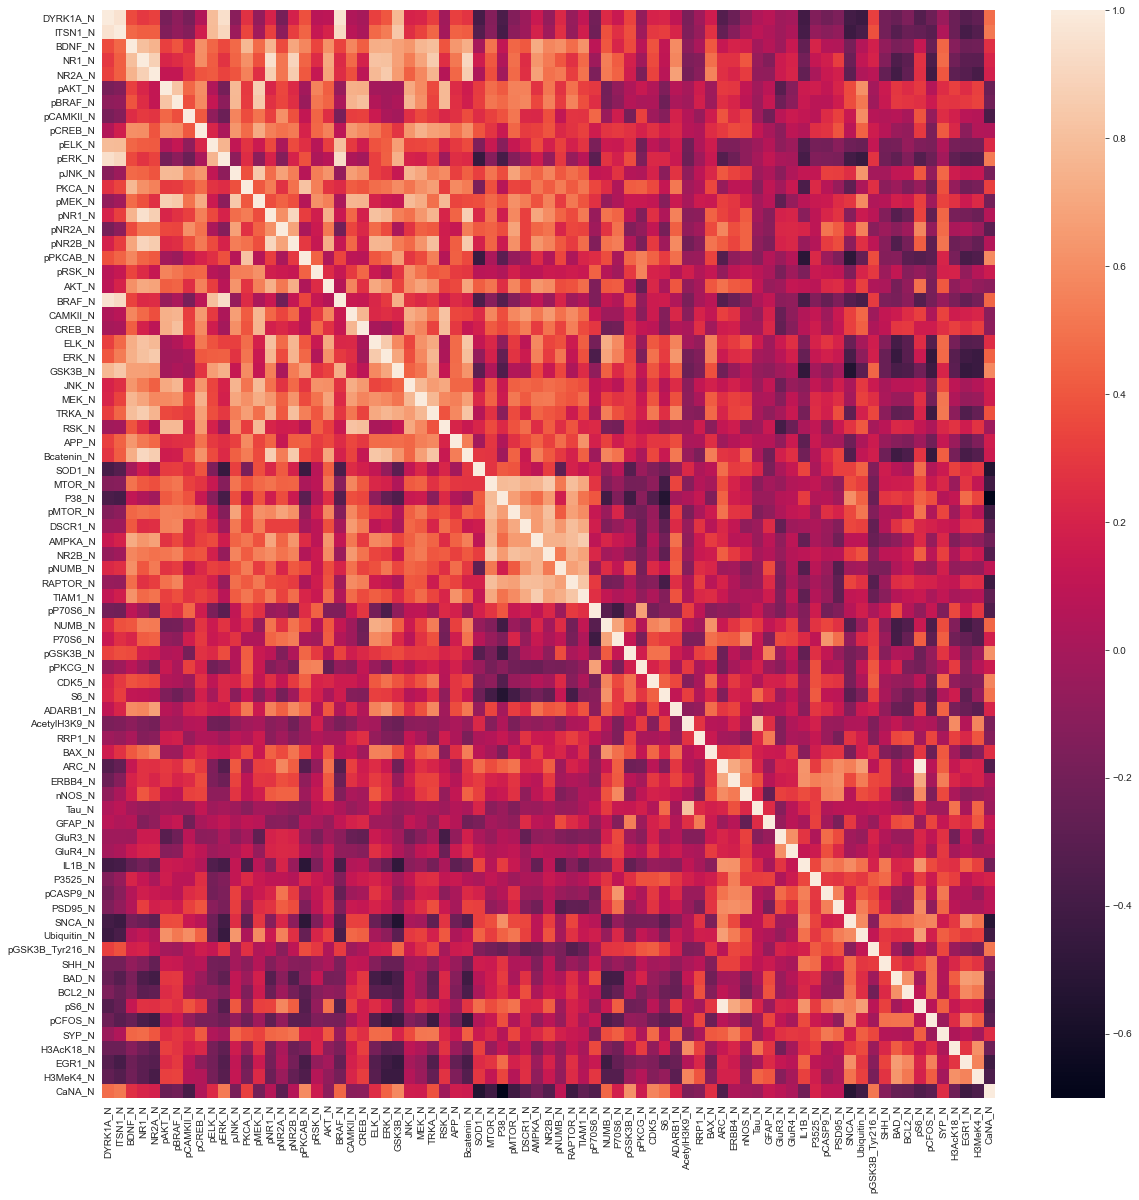

In [15]:
plt.figure(figsize=(20,20))
sns.heatmap(df.corr());

## Visualization

### Dimensionality reduction with Principal Component Analysis (PCA)

In [16]:
data_3d_pca = PCA(n_components=3).fit_transform(df)

Text(0.5, 0, 'Component 3')

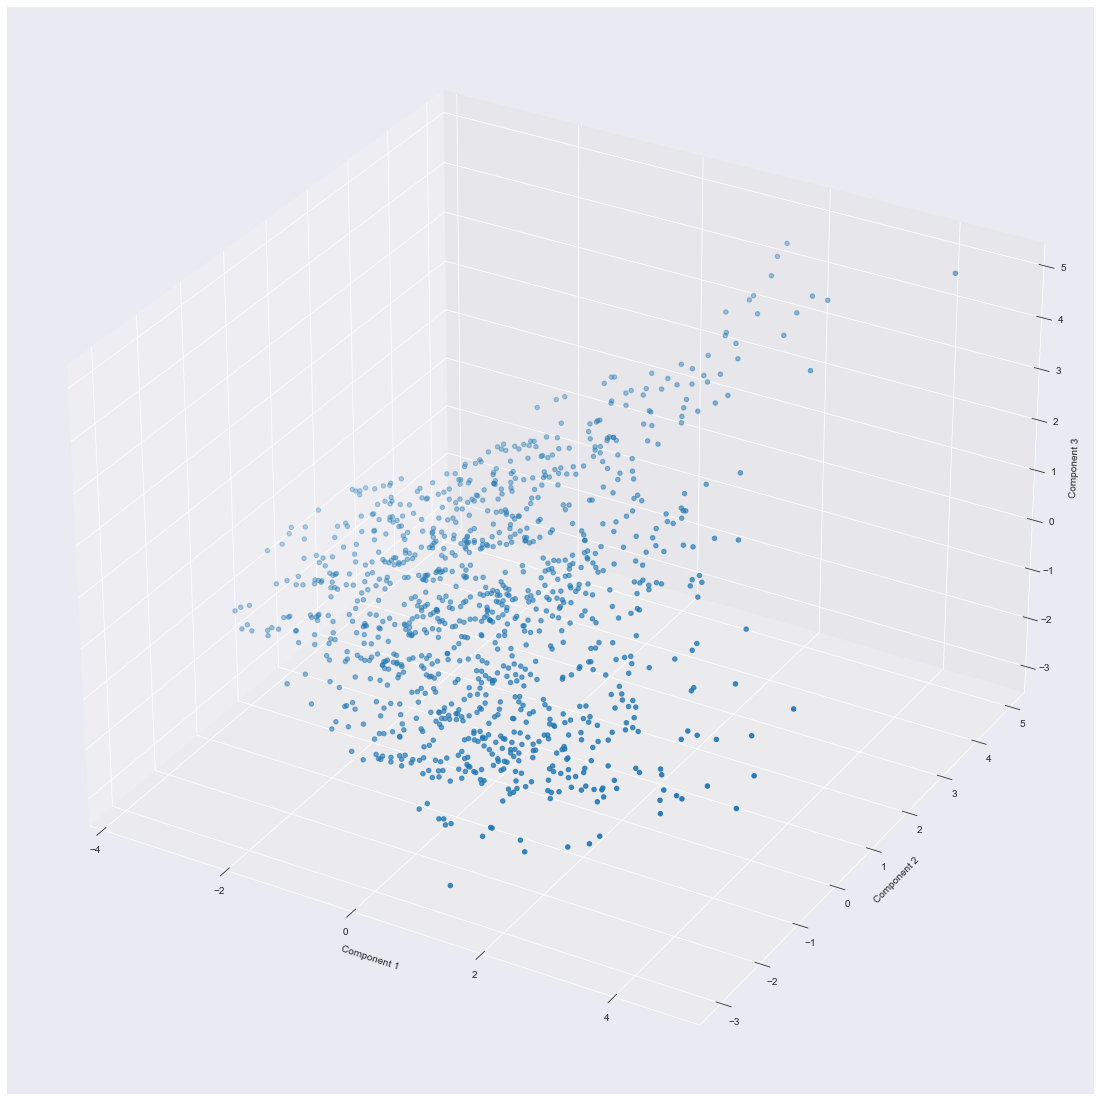

In [17]:
fig = plt.figure(figsize = (20, 20))
ax = plt.axes(projection ="3d")

p = ax.scatter3D(data_3d_pca[:,0], data_3d_pca[:,1], data_3d_pca[:,1])

ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')
ax.set_zlabel('Component 3')

In [18]:
data_2d_pca = PCA(n_components=2).fit_transform(df)

<AxesSubplot:>

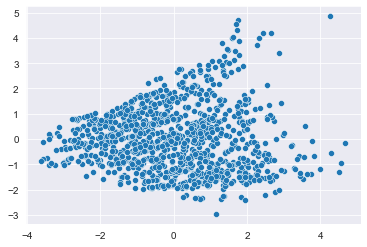

In [19]:
sns.scatterplot(x=data_2d_pca[:,0], y=data_2d_pca[:,1])

### Dimensionality reduction with t-SNE

In [20]:
data_3d_tsne = TSNE(n_components=3).fit_transform(df)

Text(0.5, 0, 'Component 3')

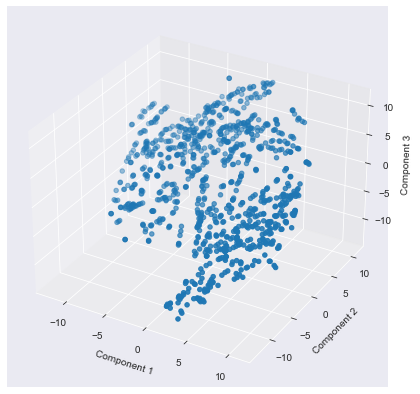

In [21]:
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")

p = ax.scatter3D(data_3d_tsne[:,0], data_3d_tsne[:,1], data_3d_tsne[:,1])

ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')
ax.set_zlabel('Component 3')

In [22]:
data_2d_tsne = TSNE(n_components=2).fit_transform(df)

<AxesSubplot:>

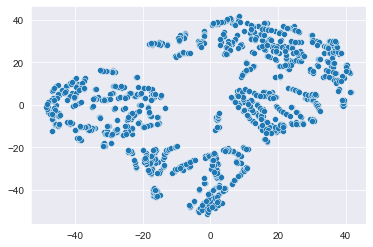

In [23]:
sns.scatterplot(x=data_2d_tsne[:,0], y=data_2d_tsne[:,1])

According to the visualizations the data form approximately into 4 clusters, so in the Clustering part of this exercise we are going to run the algorithms to get 4 clusters.

# Clustering

## Gaussian Mixture Models

In order to set the number of mixture components, we have to make estimates about the latent variables to which the observed data are related. In the Visualization part of this exercise we estimated that the data are in 4 clusters, so this will be the value to which `n_components` is going to be initialized.

In [24]:
clustering_gm = GaussianMixture(n_components=4)
clustering_gm.fit(df)
gm_labels = clustering_gm.predict(df)

The GMMs do not perform well in high dimensional settings, so we are going to try an approaoch with dimensionality reduction before applying the clustering algorithm. We are going to use PCA to perserve 99% of the variance in the projected data.

In [25]:
from sklearn.decomposition import PCA
pca = PCA(0.99)
df_reduced = pca.fit_transform(df)

As we can see PCA reduced our data to 21 dimensions while perserving 99% of the variance.

In [26]:
df_reduced.shape

(1080, 21)

In [27]:
clustering_gm_reduced = GaussianMixture(n_components=4)
clustering_gm_reduced.fit(df)
gm_labels_reduced = clustering_gm_reduced.predict(df)

## K-Means

In [28]:
clustering_kmeans = KMeans(n_clusters = 4)
clustering_kmeans.fit(df)
kmeans_labels = clustering_kmeans.labels_

## Hierarchical Clustering

Ward linkage

In [29]:
clustering_agglomerative = AgglomerativeClustering(n_clusters=4, linkage='ward')
clustering_agglomerative.fit(df)
agglomerative_labels_ward = clustering_agglomerative.labels_

Complete linkage

In [30]:
clustering_agglomerative = AgglomerativeClustering(n_clusters=4, linkage='complete')
clustering_agglomerative.fit(df)
agglomerative_labels_complete = clustering_agglomerative.labels_

Average linkage

In [31]:
clustering_agglomerative = AgglomerativeClustering(n_clusters=4, linkage='average')
clustering_agglomerative.fit(df)
agglomerative_labels_average = clustering_agglomerative.labels_

Single linkage

In [32]:
clustering_agglomerative = AgglomerativeClustering(n_clusters=4, linkage='single')
clustering_agglomerative.fit(df)
agglomerative_labels_single = clustering_agglomerative.labels_

## DBSCAN
In order to estimate `eps` and `min_samples` many attempts were made, and the current values were chosen because they provide the best results possible given the fact that domain knowledge for data is not known.

In [33]:
clustering_dbscan = DBSCAN(eps=0.99, min_samples=10)
clustering_dbscan.fit(df)
dbscan_labels = clustering_dbscan.labels_

# Visualization of the clustered data

Before we visualize the data we need to perform dimensionality redcution, t-SNE is going to be used with reduction to 2 and 3 dimensions.

Dimensionality reduction down to 2 dimensions.

In [34]:
data_2d_tsne = TSNE(n_components=2).fit_transform(df)

Dimensionality reduction down to 3 dimensions.

In [35]:
data_3d_tsne = TSNE(n_components=3).fit_transform(df)

## Gaussian Mixture Models

Dimensionality reduction down to two dimensions

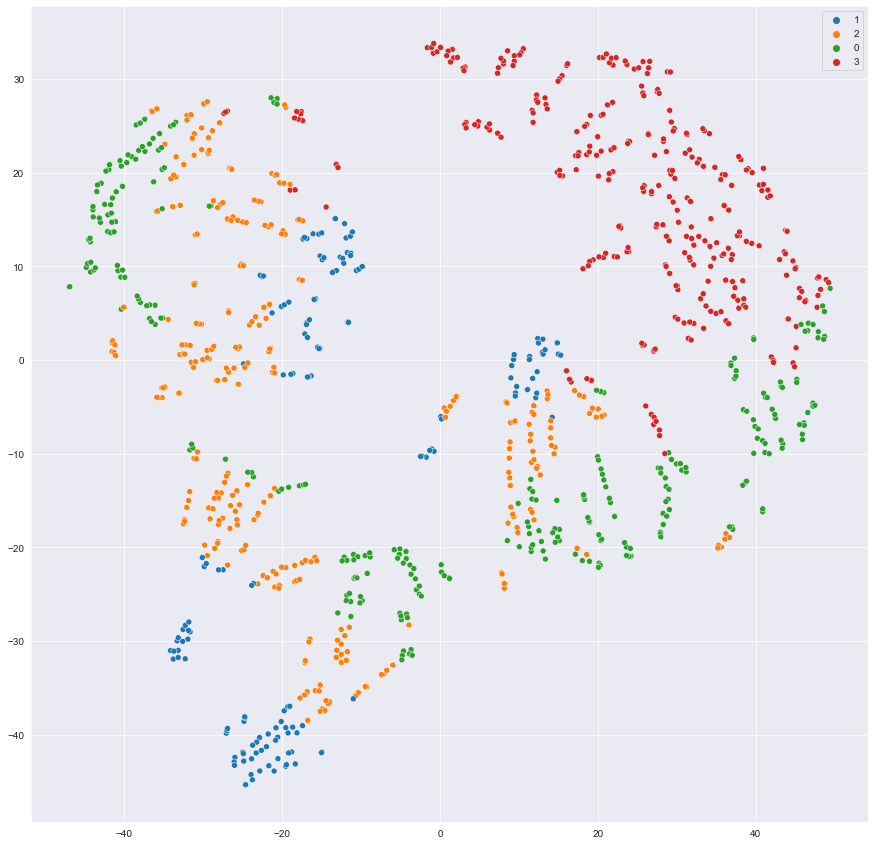

In [36]:
visualize_clustered_data_2d(data_2d_tsne, gm_labels, {"algorithm": "Gaussian Mixture Model", "n_clusters": "4", "params":"default"})

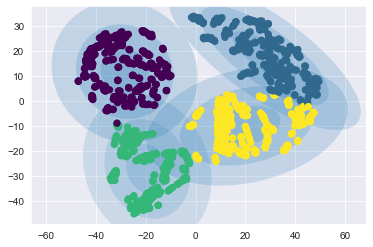

In [37]:
clustering_gm = GaussianMixture(n_components=4)
plot_gmm(clustering_gm, data_2d_tsne)

Dimensionality reduction down to three dimensions

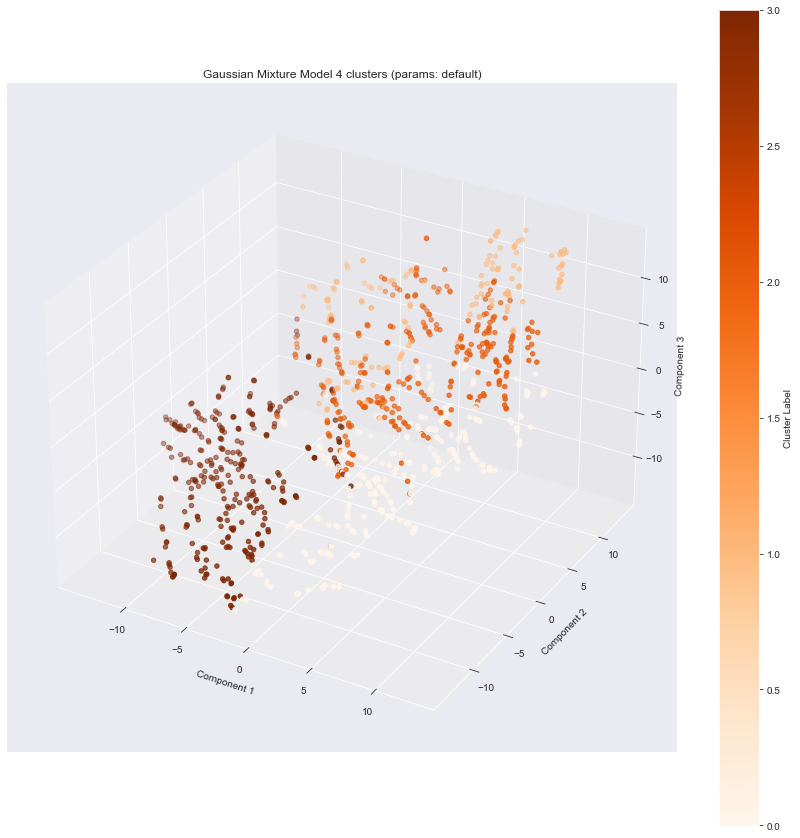

In [38]:
visualize_clustered_data_3d(data_3d_tsne, gm_labels, {"algorithm": "Gaussian Mixture Model", "n_clusters": "4", "params":"default"})

### Reduced Dimensionality Model

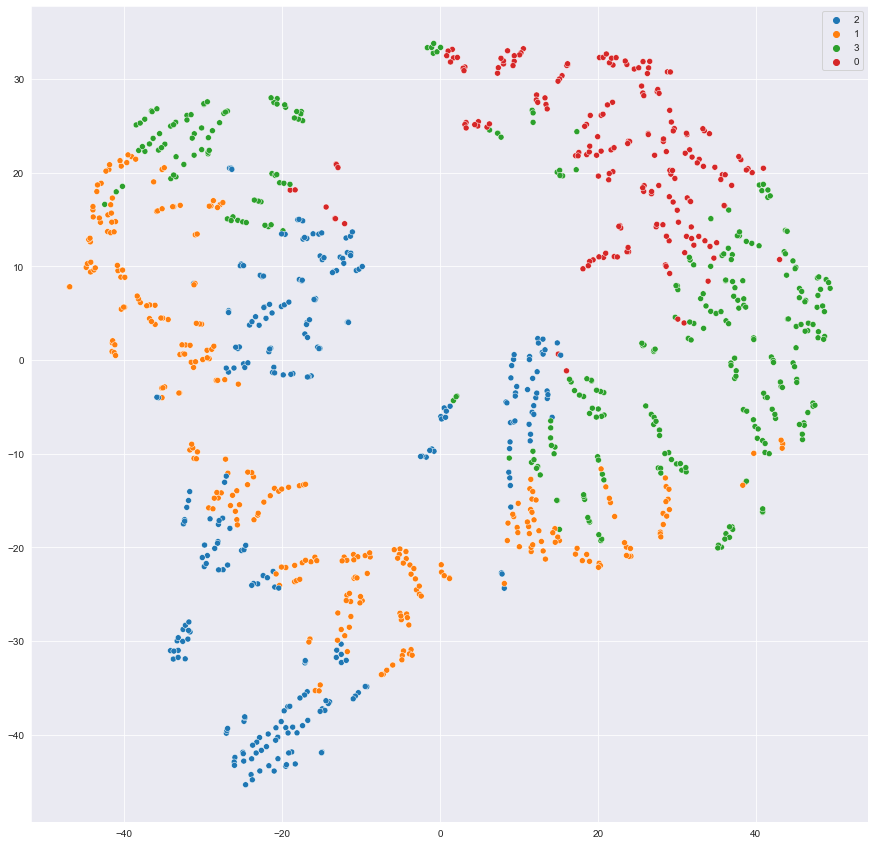

In [39]:
visualize_clustered_data_2d(data_2d_tsne, gm_labels_reduced, {"algorithm": "Gaussian Mixture Model", "n_clusters": "4", "params":"default"})

## K-Means

Dimensionality reduction down to two dimensions

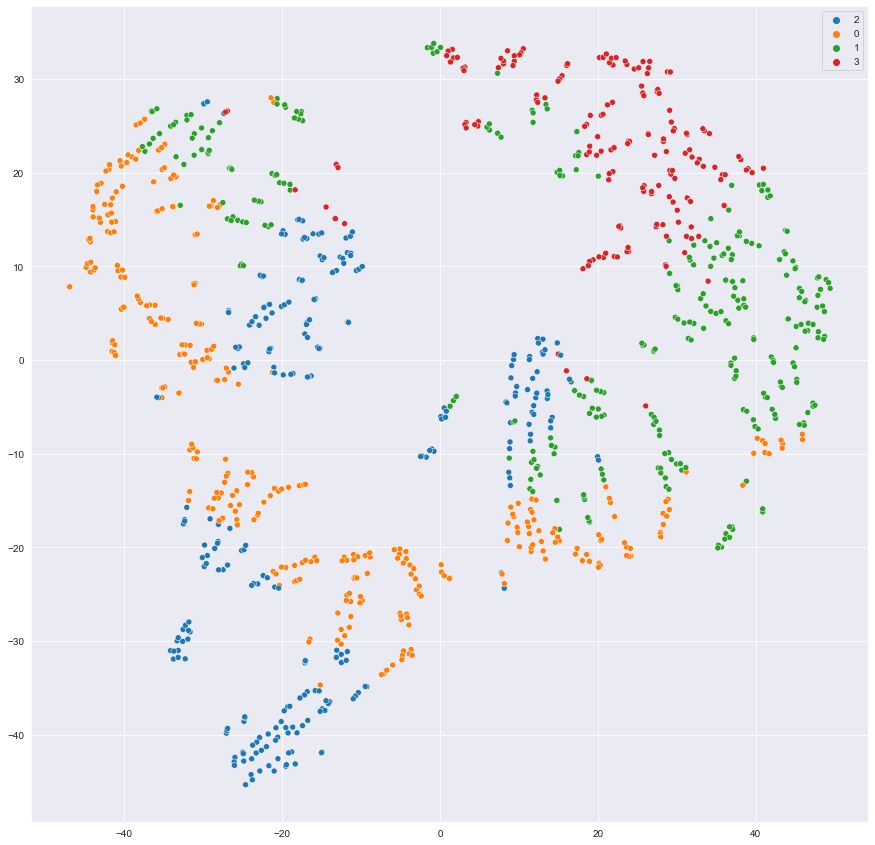

In [40]:
visualize_clustered_data_2d(data_2d_tsne, kmeans_labels, {"algorithm": "KMeans", "n_clusters": "4", "params":"default"})

Dimensionality reduction down to three dimensions

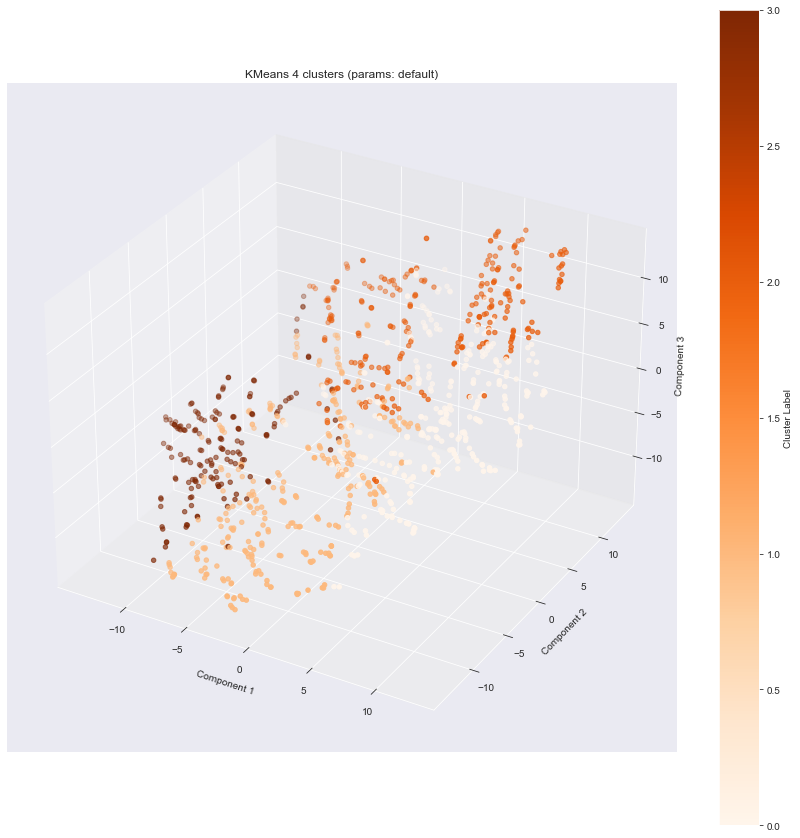

In [41]:
visualize_clustered_data_3d(data_3d_tsne, kmeans_labels, {"algorithm": "KMeans", "n_clusters": "4", "params":"default"})

## Hierarchical Clustering

Dimensionality reduction down to two dimensions

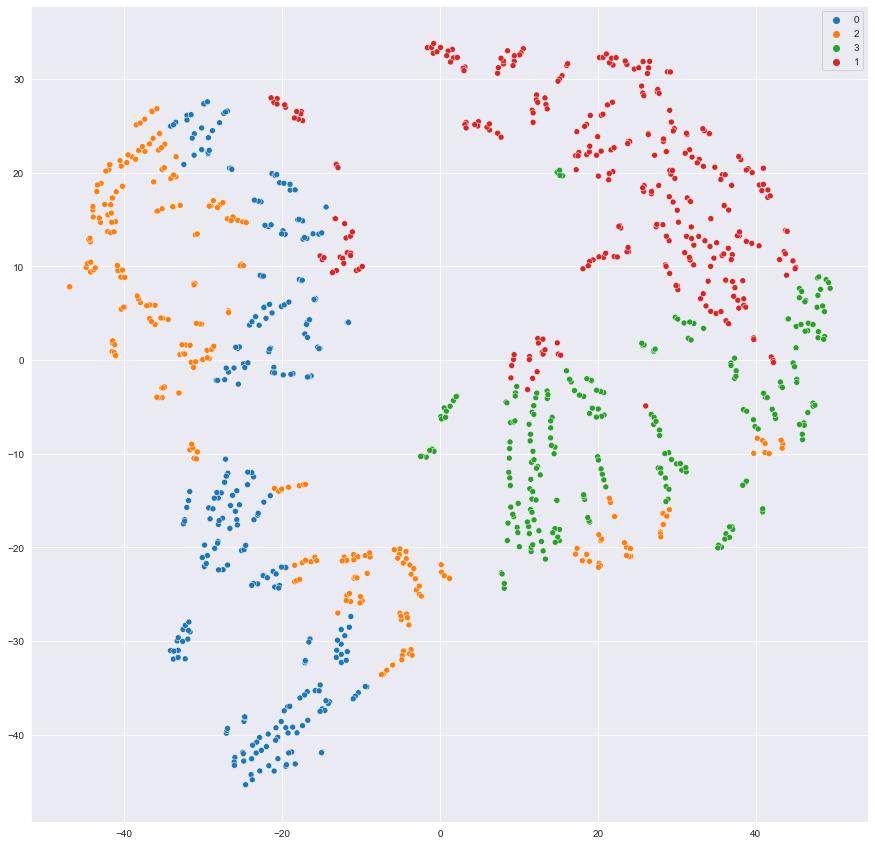

In [42]:
visualize_clustered_data_2d(data_2d_tsne, agglomerative_labels_ward, {"algorithm": "Agglomerative", "n_clusters": "4", "params":"linkage: ward"})

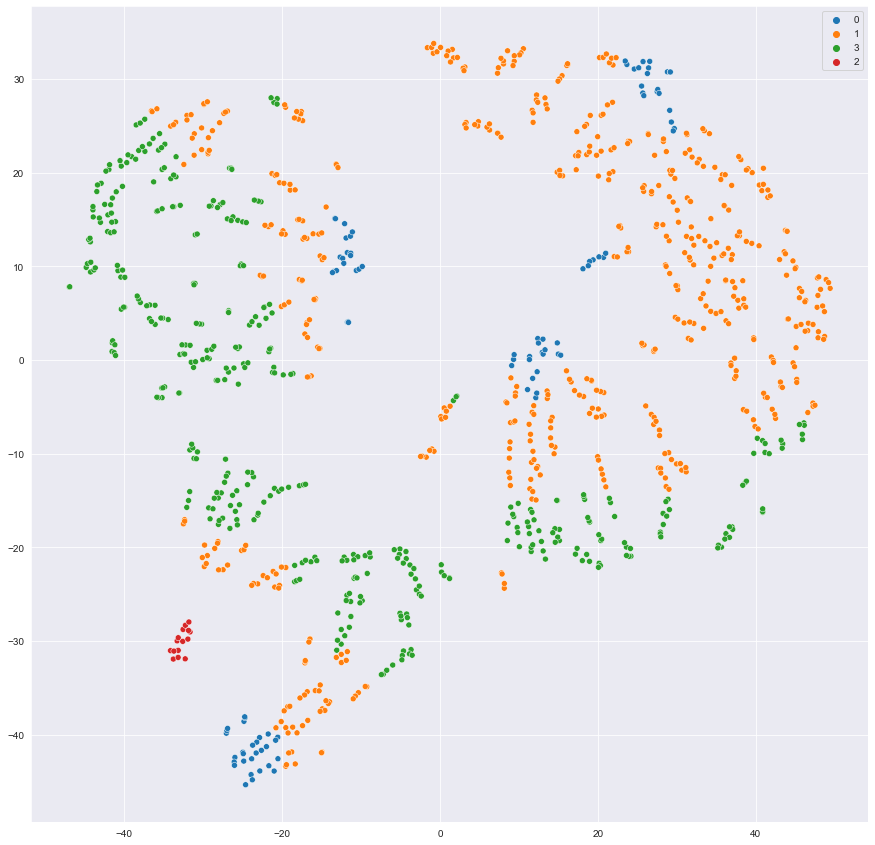

In [43]:
visualize_clustered_data_2d(data_2d_tsne, agglomerative_labels_complete, {"algorithm": "Agglomerative", "n_clusters": "4", "params":"linkage: complete"})

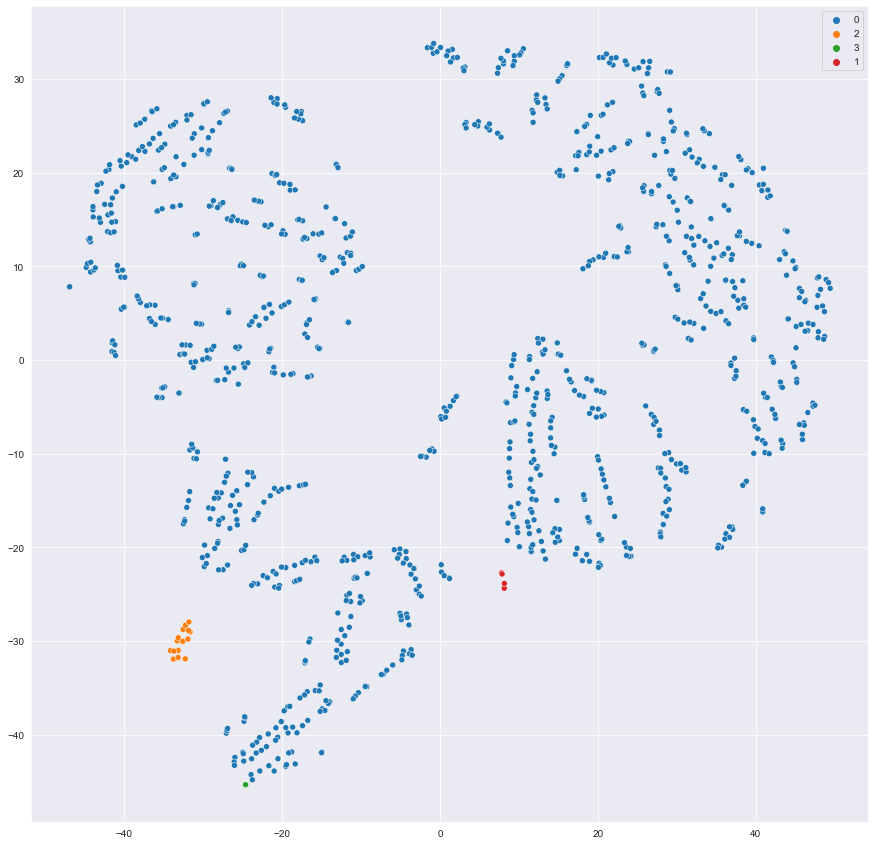

In [44]:
visualize_clustered_data_2d(data_2d_tsne, agglomerative_labels_average, {"algorithm": "Agglomerative", "n_clusters": "4", "params":"linkage: average"})

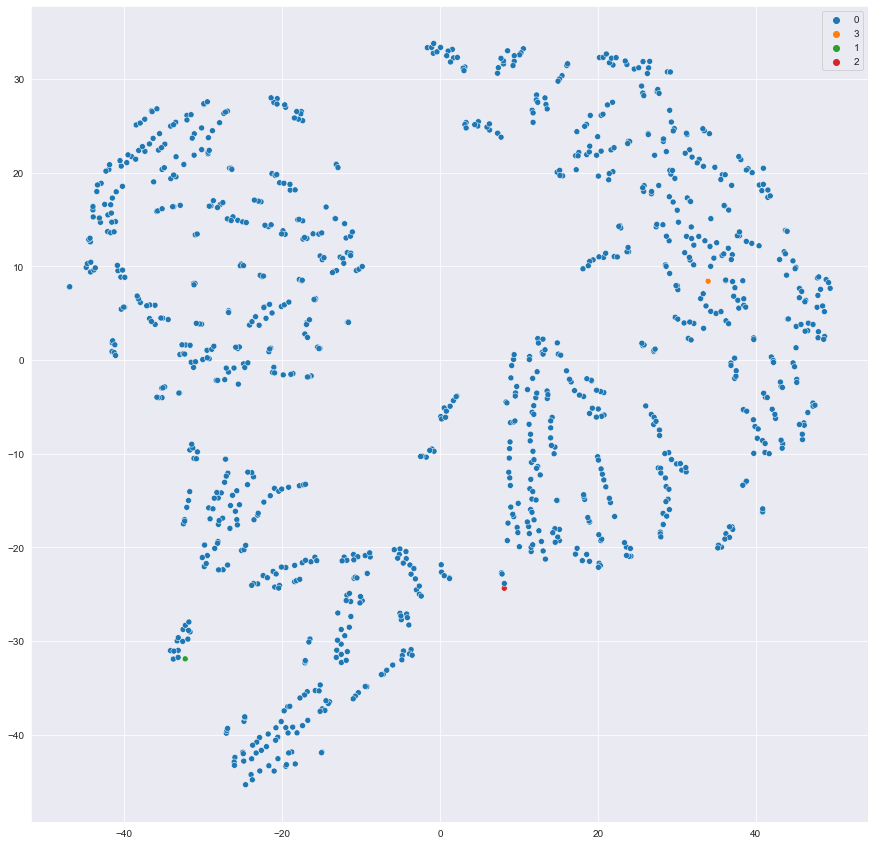

In [45]:
visualize_clustered_data_2d(data_2d_tsne, agglomerative_labels_single, {"algorithm": "Agglomerative", "n_clusters": "4", "params":"linkage: single"})

Dimensionality reduction down to three dimensions

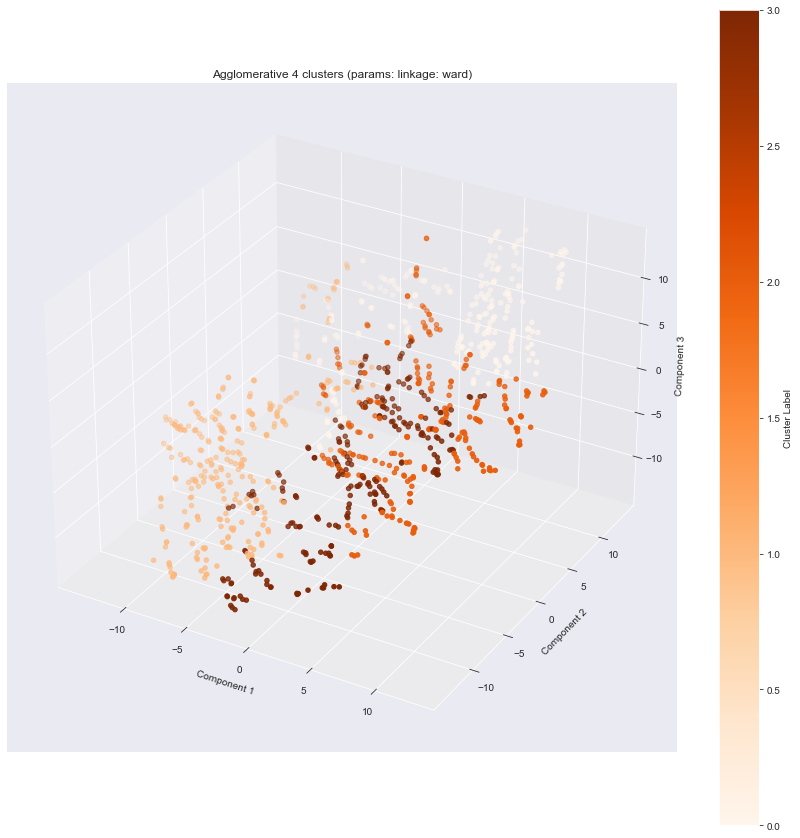

In [46]:
visualize_clustered_data_3d(data_3d_tsne, agglomerative_labels_ward, {"algorithm": "Agglomerative", "n_clusters": "4", "params":"linkage: ward"})

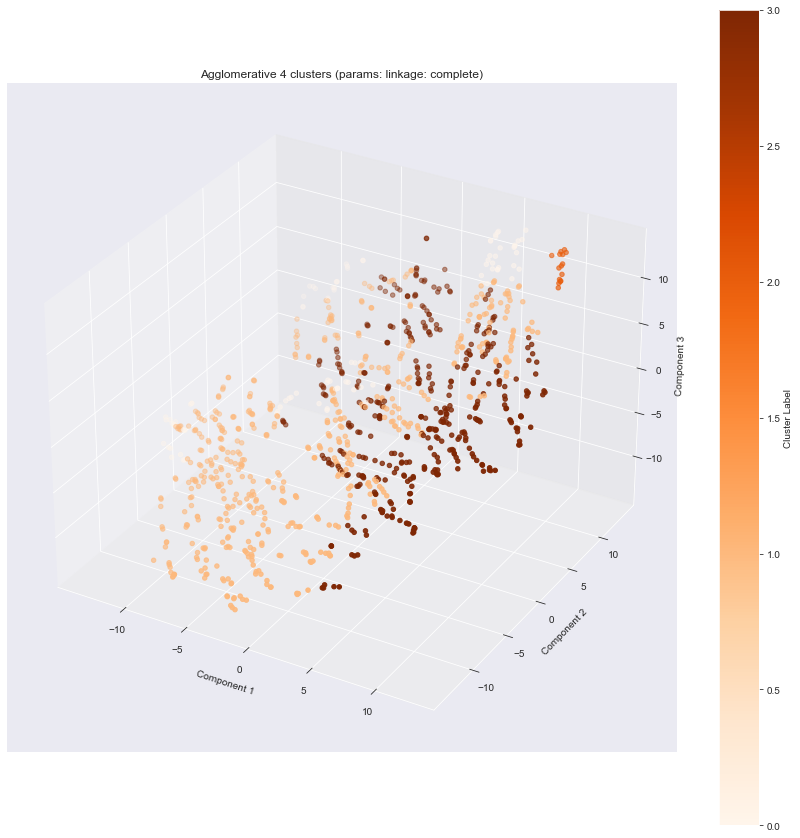

In [47]:
visualize_clustered_data_3d(data_3d_tsne, agglomerative_labels_complete, {"algorithm": "Agglomerative", "n_clusters": "4", "params":"linkage: complete"})

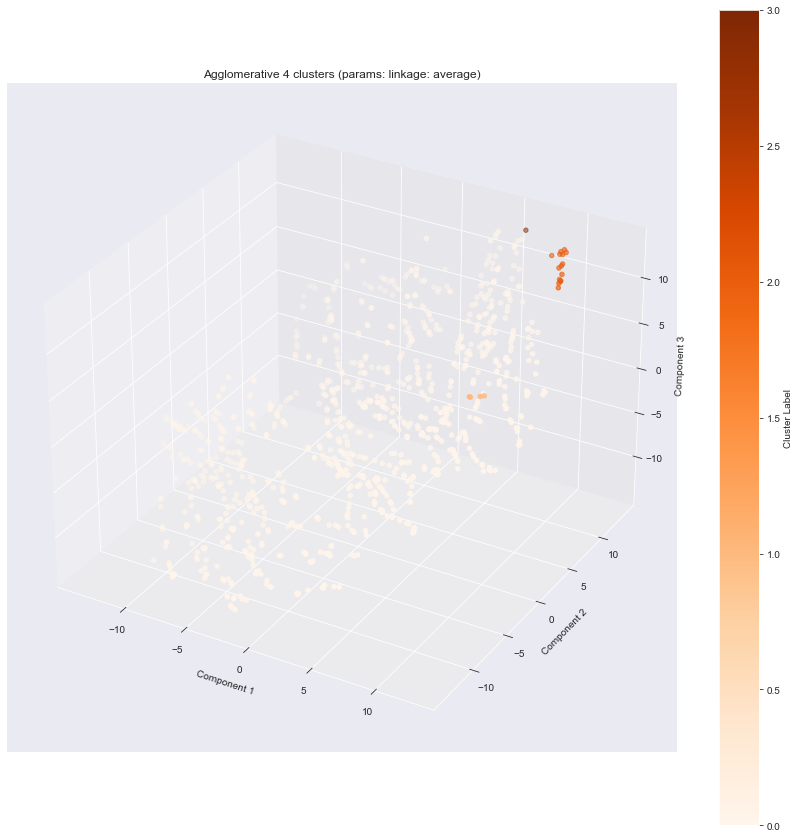

In [48]:
visualize_clustered_data_3d(data_3d_tsne, agglomerative_labels_average, {"algorithm": "Agglomerative", "n_clusters": "4", "params":"linkage: average"})

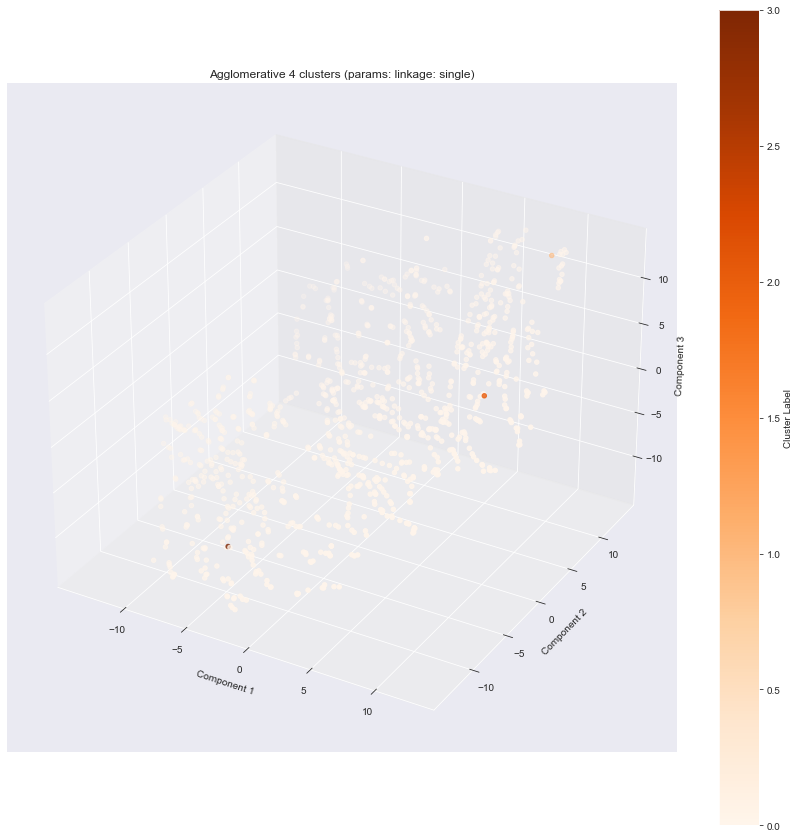

In [49]:
visualize_clustered_data_3d(data_3d_tsne, agglomerative_labels_single, {"algorithm": "Agglomerative", "n_clusters": "4", "params":"linkage: single"})

## DBSCAN

Dimensionality reduction down to two dimensions

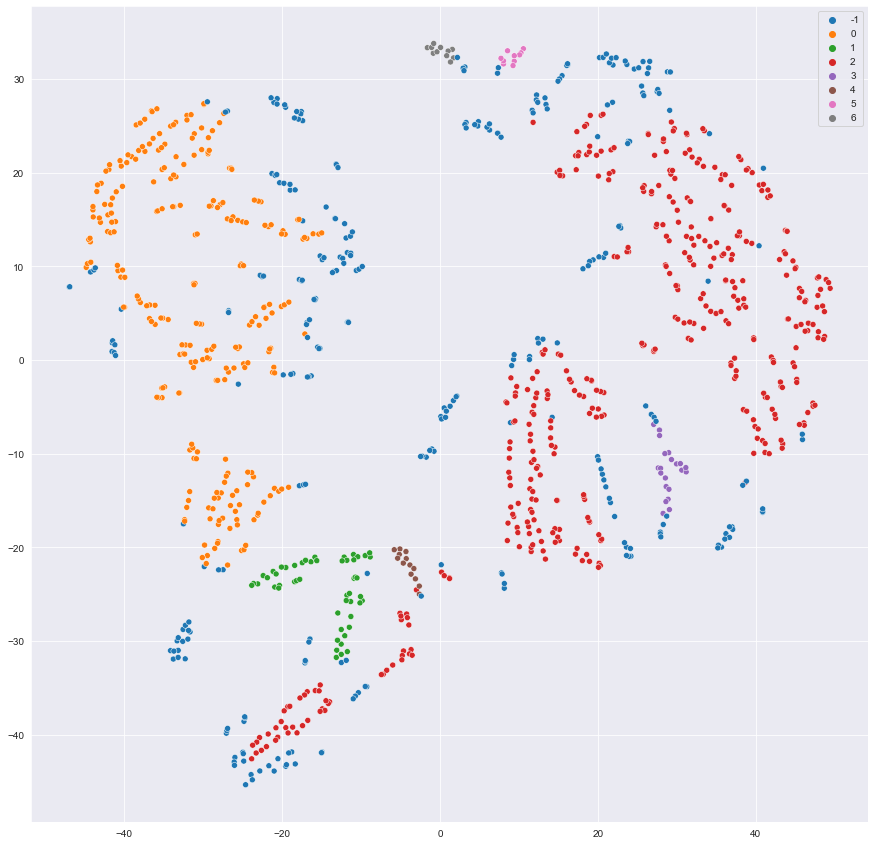

In [50]:
visualize_clustered_data_2d(data_2d_tsne, dbscan_labels, {"algorithm": "DBSCAN", "n_clusters": len(set(clustering_dbscan.labels_))-1, "params":"default"})

Dimensionality reduction down to three dimensions

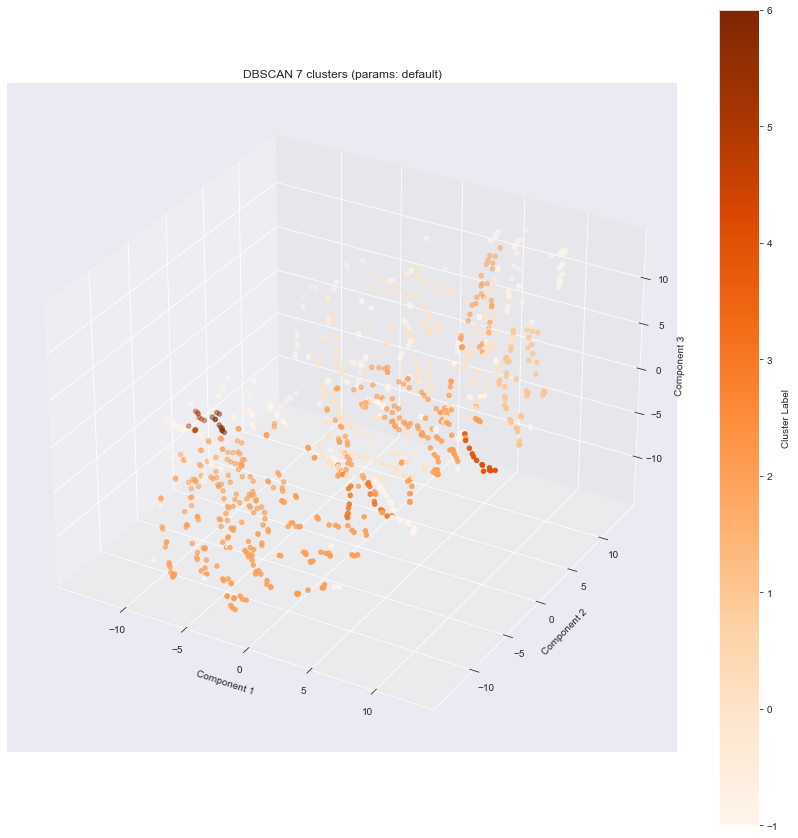

In [51]:
visualize_clustered_data_3d(data_3d_tsne, dbscan_labels, {"algorithm": "DBSCAN", "n_clusters": len(set(clustering_dbscan.labels_))-1, "params":"default"})

# <font color="magenta">Conclusion and evaluation of the results</font>

Agglomerative Clustering with ward linkage and DBSCAN with (`eps=0.99`, `min_samples=10`) provided the best clustering results of these unlabeled data. It should be considered that the lack of knowledge about data could make our assumptions not good.